In [106]:
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
project_dir = os.path.join(nb_dir, os.pardir)

if project_dir not in sys.path:
   sys.path.append(project_dir)

from src import corpus

# Load up the songs

In [107]:
songs = corpus.load_songs(corpus.processed_data_dirs()[0])

# NLTK default english stop words

In [108]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

# Custom stop words list

In [109]:
print(corpus.stop_words())

['a', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'among', 'an', 'and', 'another', 'any', 'anybody', 'anyone', 'anything', 'anywhere', 'are', 'area', 'areas', 'around', 'as', 'ask', 'asked', 'asking', 'asks', 'at', 'away', 'b', 'back', 'backed', 'backing', 'backs', 'be', 'became', 'because', 'become', 'becomes', 'been', 'before', 'began', 'behind', 'being', 'beings', 'best', 'better', 'between', 'big', 'both', 'but', 'by', 'c', 'came', 'can', 'cannot', 'case', 'cases', 'certain', 'certainly', 'clear', 'clearly', 'come', 'could', 'd', 'did', 'differ', 'different', 'differently', 'do', 'does', 'done', 'down', 'down', 'downed', 'downing', 'downs', 'during', 'e', 'each', 'early', 'either', 'end', 'ended', 'ending', 'ends', 'enough', 'even', 'evenly', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'f', 'face', 'faces', 'fact', 'facts', 'far', 'felt', 'few', 'find', 'finds', 'first

# Get normalized frequency of words

Look at all distributions of words in a song individually and normalize by the number of songs. This is a better approach than looking at each word as a total bag of words in all songs. Some of these songs have super repitive words in one song which throws off the overall distribution.

In [110]:
import string
import unicodedata
import sys

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

import pandas as pd

punc_tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(punc_tbl)

def remove_stop_words(words):
    """Remove stop words from a list of words."""
    wl = []    
    stop_words = corpus.stop_words()
    for word in words:
        word = word.lower()
        if word not in stop_words:
            wl.append(word)
    
    return wl

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = remove_stop_words(word_tokenize(remove_punctuation(song['lyrics'])))    
    dist = FreqDist(song['word_lyrics'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

# Plot the word distributions

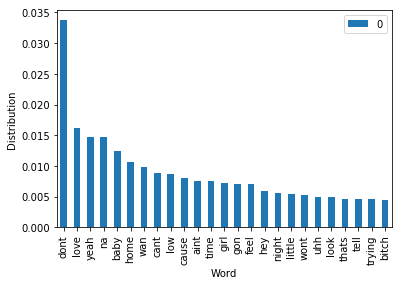

In [111]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar')
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Normalize and stem words

In [112]:
from nltk.stem import PorterStemmer

def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_lyrics'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

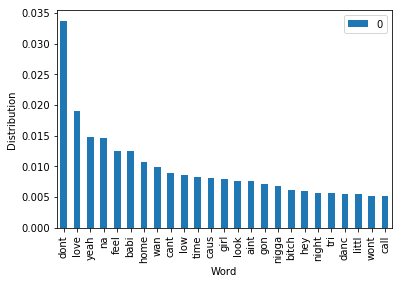

In [113]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar')
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Stemmed and normalized swear word frequency

In [114]:
swear_words = set(stem_words(corpus.swear_words()))

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_lyrics'])

    for sw in swear_words:
        if not sw in normalized_word_frequencies:
            normalized_word_frequencies[sw] = 0

        normalized_word_frequencies[sw] = normalized_word_frequencies[sw] + dist.freq(sw)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

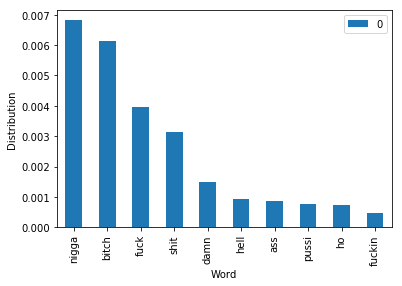

In [115]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(10, 0).plot(kind='bar')
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Sentiment analysis with Vader

In [116]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


def split_sentences(text):
    sentences = []
    for sentence in text.split('\n'):
        sentence = sentence.strip()
        
        if sentence:
            sentences.append(sentence)

    return sentences


def sentiment_for_song(text):
    sid = SentimentIntensityAnalyzer()

    # can't use sent_tokenize with lyrics... just split on newline
    sentences = split_sentences(text)
    total_ss = {
        'negative': 0,
        'positive': 0,
        'neutral': 0,
        'compound': 0
    }

    for sentence in sentences:
        ss = sid.polarity_scores(sentence)
        total_ss['negative'] = total_ss['negative'] + ss['neg']
        total_ss['positive'] = total_ss['positive'] + ss['pos']
        total_ss['neutral'] = total_ss['neutral'] + ss['neu']
        total_ss['compound'] = total_ss['compound'] + ss['compound']
        
    for key in total_ss:
        total_ss[key] = total_ss[key] / len(sentences)
        
    return total_ss

all_sentiments = {}
for song in songs:
    sentiments = sentiment_for_song(song['lyrics'])

    # add sentiment to song data
    song['positive_sentiment'] = sentiments['positive']
    song['negative_sentiment'] = sentiments['negative']
    song['neutral_sentiment'] = sentiments['neutral']
    
    for key in sentiments:
        if key not in all_sentiments:
            all_sentiments[key] = 0
            
        all_sentiments[key] = all_sentiments[key] + sentiments[key]

# normalize for number of songs
for key in all_sentiments:
    all_sentiments[key] = all_sentiments[key] / len(songs)

print(all_sentiments)

{'negative': 0.08538988774533011, 'positive': 0.11905898567659678, 'neutral': 0.7955515403012989, 'compound': 0.03935044543716692}


# Plot sentiments

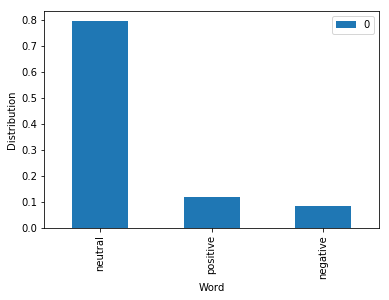

In [117]:
all_sentiments.pop('compound', 0)
df = pd.DataFrame.from_dict(all_sentiments, orient='index')
sent_plot = df.nlargest(10, 0).plot(kind='bar')
sent_plot.set_xlabel("Word")
sent_plot.set_ylabel("Distribution")

# 5 most negative songs

In [118]:
songs_df = pd.DataFrame.from_dict(songs)
songs_df.nlargest(5, 'negative_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_last_week,rank_this_week,title,word_lyrics
18,Jon Bellion,Low low low low low\nLow low low low low low l...,jon-bellion-all-time-low.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.648732,0.314293,0.036976,22,19,All Time Low,"[low, low, low, low, low, low, low, low, low, ..."
64,Auli'i Cravalho,I got this feeling on the summer day when you ...,aulii-cravalho-how-far-ill-go.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.342167,0.566556,0.091278,67,65,How Far I'll Go,"[feel, summer, day, gone, crash, car, bridg, w..."
88,Marshmello,I'm so alone\nNothing feels like home\nI'm so ...,marshmello-alone.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.267000,0.642000,0.091000,60,89,Alone,"[feel, home, tri, home, feel, home, tri, home,..."
98,Ugly God,I drip on your bitch like water\nI splash on y...,ugly-god-water.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.266914,0.551886,0.181229,80,99,Water,"[drip, bitch, water, splash, bitch, water, fee..."
60,21 Savage & Metro Boomin,"\nYoung Savage, why you trappin' so hard?\nWhy...",21-savage-metro-boomin-no-heart.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.219706,0.716279,0.064000,50,61,No Heart,"[savag, trappin, hard, nigga, cappin, hard, 12..."


# 5 most positive songs

In [119]:
songs_df.nlargest(5, 'positive_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_last_week,rank_this_week,title,word_lyrics
37,Sia Featuring Kendrick Lamar,"Uh-oh, running out of breath, but I\nOh, I, I ...",sia-featuring-kendrick-lamar-the-greatest.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.014704,0.579225,0.406085,39,38,The Greatest,"[uhoh, run, breath, stamina, uhoh, run, close,..."
32,John Legend,"Pulling me further, further than I've been bef...",john-legend-love-me-now.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.059218,0.641345,0.299418,31,33,Love Me Now,"[pull, ive, stronger, shake, core, dont, what,..."
34,Little Big Town,I know I'm probably better off on my own\nThan...,little-big-town-better-man.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.044571,0.659024,0.296286,41,35,Better Man,"[probabl, own, love, didnt, perman, damag, wis..."
90,John Mayer,"\nIt's a Friday, we finally made it\nI can't b...",john-mayer-love-on-the-weekend.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.028432,0.684568,0.287027,0,91,Love On The Weekend,"[friday, final, cant, believ, youv, ive, wait,..."
69,Andy Grammer,"I got these fresh eyes, never seen you before ...",andy-grammer-fresh-eyes.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.027200,0.727857,0.244943,68,70,Fresh Eyes,"[fresh, eye, seen, god, beauti, time, door, us..."


# 5 most neutral songs

In [120]:
songs_df.nlargest(5, 'neutral_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_last_week,rank_this_week,title,word_lyrics
51,Marian Hill,Didn't even really wanna go\nBut if you get me...,marian-hill-down.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.018386,0.955159,0.026455,99,52,Down,"[didnt, wan, na, there, bodi, floor, babi, add..."
68,Brett Eldredge,The radio and a sundress\nMakin' my world all ...,brett-eldredge-wanna-be-that-song.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.038955,0.952212,0.008833,64,69,Wanna Be That Song,"[radio, sundress, makin, world, mess, corner, ..."
76,Luis Fonsi Featuring Daddy Yankee,"Ay \nFonsi \nDY \nOh oh… \nOh no, oh no… \nOh ...",luis-fonsi-featuring-daddy-yankee-despacito.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.016727,0.945045,0.038227,88,77,Despacito,"[ay, fonsi, dy, yeah, dididiri, daddi, sí, sab..."
67,Alessia Cara,Wooohhhh\n\nYou sheltered me from harm\nKept m...,alessia-cara-how-far-ill-go.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.015731,0.929423,0.054846,56,68,How Far I'll Go,"[wooohhhh, shelter, harm, kept, warm, kept, wa..."
63,Khalid,\n\n\n\nSend me your location lets\nFocus on c...,khalid-location.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.016184,0.926105,0.057711,70,64,Location,"[send, locat, focu, commun, cuz, time, chanc, ..."


# How repititive?

Check how repititive a song is by looking at the number of occurences each phrase or sentence has. A lot of songs are repititive due to the nature of a chorus etc.. however some might be super repititve.

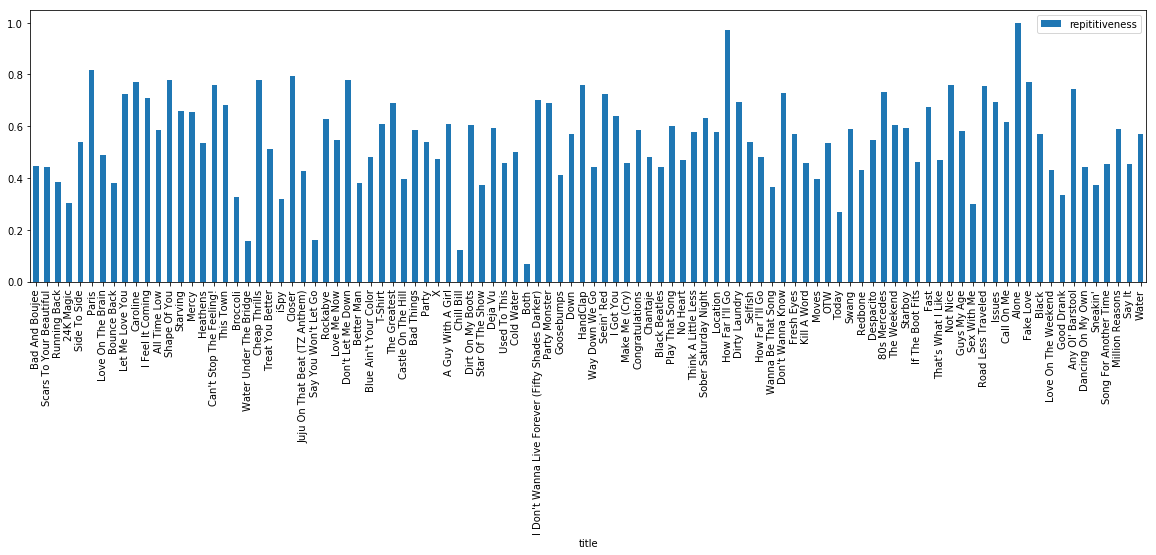

In [121]:
def song_repitiveness(lyrics, rate=2):
    # split song on sentence and find unique sentences
    sentences = split_sentences(lyrics)
    unique_sentences = set(sentences)
    
    total_sentences = len(sentences)
    total_unique_sentences = len(unique_sentences)
    
    # collect counts of unique sentence occurrences
    counts = []
    count = 0
    for usentence in unique_sentences:
        for sentence in sentences:
            if usentence == sentence:
                count = count + 1
        
        counts.append(count)
        count = 0
        
    # calculate repititiveness rate and throw away occurrences of given rate
    # this sets a threshold on how many occurrences must appear to be considered
    # repititive
    repititive_rate = 0
    for count in counts:
        if count < rate:
            continue
            
        repititive_rate = repititive_rate + (count / total_sentences)
        
    return repititive_rate

# songs[98]
# water = songs[98]

# song_repitiveness(water['lyrics'], rate=2)

for song in songs:
    song['repititiveness'] = song_repitiveness(song['lyrics'], rate=2)
    
songs_df = pd.DataFrame.from_dict(songs)
songs_df.sort_values('rank_this_week').plot(x='title', y=('repititiveness'), kind='bar', stacked=True, figsize=(20,5))

In [122]:

lyrics = songs_df['lyrics'].where(songs_df['title'] == "I Feel It Coming", '').max()
lyrics

"Yeah, uh\n\n\nTell me what you really like\nBaby I can take my time\nWe don't ever have to fight\nJust take it step-by-step\nI can see it in your eyes\n'Cause they never tell me lies\nI can feel that body shake\nAnd the heat between your legs\n\n\nYou've been scared of love and what it did to you\nYou don't have to run, I know what you've been through\nJust a simple touch and it can set you free\nWe don't have to rush when you're alone with me\n\n\nI feel it coming, I feel it coming, babe\nI feel it coming, I feel it coming, babe\nI feel it coming, I feel it coming, babe\nI feel it coming, I feel it coming, babe\n\n\nYou are not the single type\nSo baby, this the perfect time\nI'm just trying to get you high\nAnd faded off this touch\nYou don't need a lonely night\nSo baby, I can make it right\nYou just got to let me try\nTo give you what you want\n\n\nYou've been scared of love and what it did to you\nYou don't have to run, I know what you've been through\nJust a simple touch and it 